## [PRW (Person Re-identification in the Wild) Dataset](http://zheng-lab.cecs.anu.edu.au/Project/project_prw.html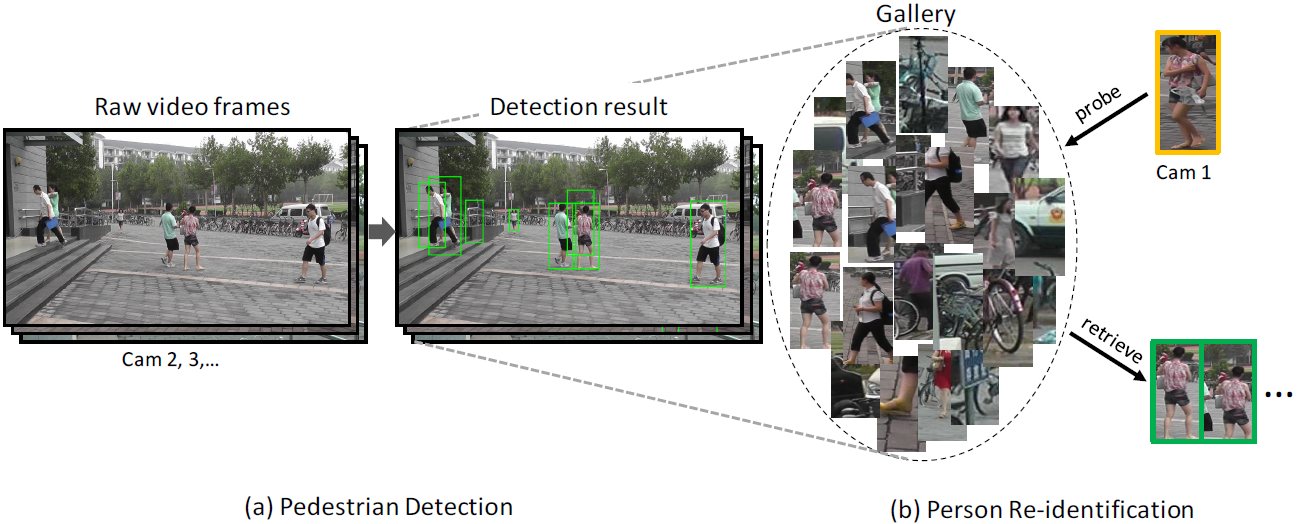)
<img src="http://zheng-lab.cecs.anu.edu.au/Project/pipeline_prw.png" width=1080/>

In [1]:
import os
import cv2
import glob
import shutil
import scipy.io
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from io import BytesIO
from os import getcwd
from xml.dom import minidom
from xml.etree import ElementTree as ET

In [2]:
 # 定義一個創建一級分支object的函數
def create_object(root, id, x1, y1, x2, y2, obj_name):   # 參數依次，樹根，xmin，ymin，xmax，ymax
    #創建一級分支object
    _object = ET.SubElement(root, 'object')
    
    #創建二級分支
    name = ET.SubElement(_object, 'name')
    name.text = str(obj_name)
    pose = ET.SubElement(_object, 'pose')
    pose.text = 'Unspecified'
    truncated = ET.SubElement(_object, 'truncated')
    truncated.text = '0'
    difficult = ET.SubElement(_object, 'difficult')
    difficult.text = '0'
    
    #創建bndbox
    bndbox = ET.SubElement(_object, 'bndbox')
    xmin = ET.SubElement(bndbox, 'xmin')
    xmin.text = '%s'%x1
    ymin = ET.SubElement(bndbox, 'ymin')
    ymin.text = '%s'%y1
    xmax = ET.SubElement(bndbox, 'xmax')
    xmax.text = '%s'%x2
    ymax = ET.SubElement(bndbox, 'ymax')
    ymax.text = '%s'%y2
    
    #創建reid
    reid = ET.SubElement(_object, 'reid')
    reid.text = '%s'%id

## 將 label 的 mat 檔轉換成 xml 檔

In [3]:
# 創建 xml 文件的函數
def create_tree(image_name, h, w):
    global annotation
    
    # 創建樹根 annotation
    annotation = ET.Element('annotation')
    
    #創建一級分支 folder
    folder = ET.SubElement(annotation, 'folder')
    folder.text = ''

    #創建一級分支 filename
    filename = ET.SubElement(annotation, 'filename')
    filename.text = image_name

    #創建一級分支 path
    path = ET.SubElement(annotation, 'path')
    path.text = image_name
    
    #創建一級分支 source
    source = ET.SubElement(annotation, 'source')
    #創建 source 下的二級分支 database
    database=ET.SubElement(source, 'database')
    database.text = 'http://zheng-lab.cecs.anu.edu.au/Project/project_prw.html'

    #創建一級分支 size
    size = ET.SubElement(annotation, 'size')
    #創建 size 下的二級分支圖像的 width, height, depth
    width = ET.SubElement(size, 'width')
    width.text = str(w)
    height = ET.SubElement(size, 'height')
    height.text = str(h)
    depth = ET.SubElement(size, 'depth')
    depth.text = '3'

    #創建一級分支segmented
    segmented = ET.SubElement(annotation, 'segmented')
    segmented.text = '0'

In [4]:
def getImagesInDir(dir_path):
    img_formats = ['bmp', 'jpg', 'jpeg', 'png', 'tif', 'tiff', 'dng']  # acceptable image suffixes
    image_list = []
    for img_format in img_formats:
        for filename in glob.glob(dir_path + f'/*.{img_format}'):
            image_list.append(filename)
    return image_list

In [5]:
def xywh2xyxy(box, height, width):
    reid, x, y, w, h = box
    x1 = int(max(x, 0))
    y1 = int(max(y, 0))
    x2 = int(min(x+w, width))
    y2 = int(min(y+h, height))
    return reid, x1, y1, x2, y2

In [6]:
img_dir = 'PRW-v16.04.20/frames'
ann_dir = 'PRW-v16.04.20/annotations'
image_paths = getImagesInDir(img_dir)

out = 'pedestrian_datasets'
if os.path.exists(out):
    shutil.rmtree(out)  # delete output folder
out_img_dir = os.path.join(out, 'JPEGImages')
os.makedirs(out_img_dir)  # make new output folder
out_ann_dir = os.path.join(out, 'Annotations')
os.makedirs(out_ann_dir)  # make new output folder
out_txt_dir = os.path.join(out, 'ImageSets/Main')
os.makedirs(out_txt_dir)  # make new output folder
out_txt_file = os.path.join(out, 'ImageSets/Main/default.txt')

In [7]:
if os.path.exists(out_txt_file):
    os.remove(out_txt_file)
for img_path in tqdm(image_paths, total=len(image_paths)):
    basename = os.path.basename(img_path)
    basename_no_ext = os.path.splitext(basename)[0]
    ann_file_path = os.path.join(ann_dir, basename) + '.mat'
    if 'box_new' in scipy.io.loadmat(ann_file_path).keys():
        ann = scipy.io.loadmat(ann_file_path)['box_new']
    elif 'anno_file' in scipy.io.loadmat(ann_file_path).keys():
        ann = scipy.io.loadmat(ann_file_path)['anno_file']
    if -2. not in ann:
        # 複製影像
        shutil.copy(img_path, os.path.join(out_img_dir, basename))

        # 轉換標籤檔
        height, width, c = cv2.imread(img_path).shape
        create_tree(basename, height, width)
        for each in ann:
            reid, x1, y1, x2, y2 = xywh2xyxy(each, height, width)
            create_object(annotation, reid, x1, y1, x2, y2, 'pedestrian')
            # 將樹模型寫入 xml 文件
            tree = ET.ElementTree(annotation)     
            xmlstr = minidom.parseString(ET.tostring(tree._root)).toprettyxml(indent=" ")
            with open('{}/{}.xml'.format(out_ann_dir, basename_no_ext), "w") as f:
                f.write(xmlstr)

        # 生成 txt
        with open(out_txt_file, 'a') as f:
            f.write(basename_no_ext+'\n')

100%|██████████| 11816/11816 [08:28<00:00, 23.22it/s] 
